In [1]:
"""
This script is used to analyze data and produce Suplementary Figures of the manuscript
'Plasmid-mediated phenotypic noise leads to transient antibiotic resistance in bacteria'.

MIT License

Copyright (c) 2023 JCRHB/RPM

""";


## System preparation


In [2]:
import pandas as pd
import numpy as np
from scipy.stats import linregress
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr
from scipy.stats import gaussian_kde


In [3]:
#%load_ext rpy2.ipython

### Mounting Gdrive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### File paths

In [5]:
rootDir="/content/drive/MyDrive/SYNC_Projects/"

rootDir=rootDir+"pBGT/GIT/"

workingDir=rootDir+"code/Supplementary/"
data_path=rootDir+"data/supplementary/sFig-13/"

sfig_path=rootDir+"figures/SuppFigures/"


In [6]:

filename=data_path+"all_strains_vmax.csv"
many_fits_single_res=pd.read_csv(filename,sep="\t")

display(many_fits_single_res.head(2))

single_strains=["WT","MGGT","pBGT","G54U","G55U"]

,strain,replicate,y0,mumax,r2
0,G54U,1,0.045912,0.354063,0.999748
1,G55U,1,0.048437,0.344448,0.999680


[[0.5053147675245413, 0.4795852742315454, 0.5042269154695419, 0.4882261283792586, 0.4958154921494138, 0.3648599494758995], [0.4561962213847961, 0.4764880843760916, 0.4879038621749254, 0.4870250969360053, 0.4894973385897749, 0.4169148948628048], [0.3728757865388414, 0.4353525749289464, 0.3338596548104364, 0.4328077025482525, 0.4390811080611627, 0.4170442989744999], [0.3540627706712143, 0.3674200301581047, 0.3150140620747365, 0.3614740151450279, 0.3417093725365889, 0.3239538250414796], [0.344448497139639, 0.3363223695415798, 0.3543259663155997, 0.3515832900012044, 0.360222886375355, 0.3618853353019421]]


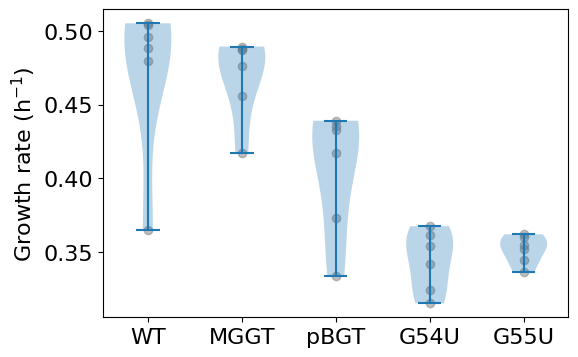

In [7]:


fig=plt.figure(figsize=(6,4))
fig.set_facecolor('white')
plt.rcParams.update({'font.size': 16})

xx=[]
mumaxs=[]

for istrain,this_strain in enumerate(single_strains):
    this_df=many_fits_single_res[many_fits_single_res["strain"]==this_strain]
    this_mumaxs=list(this_df["mumax"])
    this_x=[istrain]*len(this_mumaxs)
    xx.append(this_x)
    mumaxs.append(this_mumaxs)
    plt.scatter(this_x,this_mumaxs,alpha=.5,c='gray')
print(mumaxs)


plt.violinplot(mumaxs,positions=range(0,5))
#plt.boxplot(yy,positions=range(0,5))
plt.xticks(range(0,5),labels=single_strains)
plt.ylabel("Growth rate (h$^{-1}$)")


plt.show()


In [8]:
ref_mumax=np.mean(mumaxs[1])   ###<-- relative to MGGT
relative_fitness_mumax_mean=[]
relative_fitness_mumax_std=[]
fitness_costs_mumaxs=[]
for i,strain in enumerate(single_strains):
    this_mumaxs=mumaxs[i]
    this_mean=np.mean(this_mumaxs)
    this_sd=np.std(this_mumaxs)
    rel_mean=this_mean/ref_mumax
    rel_sd=this_sd/ref_mumax
    relative_fitness_mumax_mean.append(rel_mean)
    relative_fitness_mumax_std.append(rel_sd)
    fitness_costs_mumaxs.append(1-rel_mean)
    print(strain,this_mean,this_sd,"\t",rel_mean,rel_sd)
fitness_costs_mumaxs

WT 0.4730047545383667 0.04917550600616555 	 1.0085297837280063 0.10485087509430231
MGGT 0.469004249720733 0.02593346370100279 	 1.0 0.055294730733132555
pBGT 0.4051701876436899 0.038931294634430756 	 0.8638944911159059 0.08300840484411871
G54U 0.34393901260452536 0.01915879587706032 	 0.7333387976960181 0.04084994088746181
G55U 0.3514647241125533 0.008869551393061517 	 0.7493849454921395 0.018911452078190893


[-0.00852978372800628,
 0.0,
 0.13610550888409412,
 0.26666120230398194,
 0.2506150545078605]

## Include PCN data

In [9]:
strains_file=data_path+"strains_characterization_pBGT_evo.txt"
print(strains_file)
dfstr=pd.read_csv(strains_file,sep='\t',dtype=str)
dfstr

/content/drive/MyDrive/SYNC_Projects/pBGT/GIT/data/supplementary/sFig-13/strains_characterization_pBGT_evo.txt


,Strain name,Fitness *,PCN,CMI CAZ (mg l-1),CMI AMP (mg l-1)
0,MG,1.003 ± 0.011,NaN,0.25,4
1,MG::blaTEM-1,NaN,NaN,0.25,512
2,MG/pBGT,0.943 ± 0.013,19.12 ± 1.56,0.5,"8,192"
3,MG::blaTEM-1 R146,1.008 ± 0.011,NaN,0.5,128
4,MG/pBGT R164S,0.943 ± 0.003,21.10 ± 0.85,64,"4,096"
5,MG/pBGT G54U,0.793 ± 0.019,44.50 ± 3.81,0.5,"32,768"
6,MG/pBGT G55U,0.557 ± 0.116,88.93 ± 15.65,1,"32,768"
7,MG/pBGT R164S G54U,0.762 ± 0.016,52.30 ± 2.19,128,"4,096"
8,MG/pBGT R164S G55U,0.509 ± 0.082,127.29 ± 4.58,128,"8,192"


In [10]:
table_strains_names=["MG","MG::blaTEM-1","MG/pBGT","MG/pBGT G54U","MG/pBGT G55U"]

plt_res=[]
strain_fitness=[]
strain_pcns_raw=[]
for this_strain in table_strains_names:
    this_pcn=str(dfstr[dfstr["Strain name"]==this_strain]["PCN"].item()).replace(' ', '')
    this_res=int(dfstr[dfstr["Strain name"]==this_strain]["CMI AMP (mg l-1)"].item().replace(',', ''))
    this_fitness=str(dfstr[dfstr["Strain name"]==this_strain]["Fitness *"].item())
    if this_fitness=="nan":
        this_fitness='1'
    if this_pcn=="nan":
        this_pcn='1'
    plt_res.append(this_res)
    strain_fitness.append(this_fitness)
    strain_pcns_raw.append(this_pcn)

plt_res2=[x/plt_res[1] for x in plt_res]  #<-- relative to MGGT

strain_cost=[1-float(x.split(" ")[0]) for x in strain_fitness]
strain_pcns=[float(x.split("±")[0]) for x in strain_pcns_raw]
strain_pcns,strain_pcns_raw,strain_cost


([1.0, 1.0, 19.12, 44.5, 88.93],
 ['1', '1', '19.12±1.56', '44.50±3.81', '88.93±15.65'],
 [-0.0029999999999998916,
  0.0,
  0.05700000000000005,
  0.20699999999999996,
  0.44299999999999995])

Saving fig as: 
 /content/drive/MyDrive/SYNC_Projects/pBGT/GIT/figures/SuppFigures/sFig-13.pdf


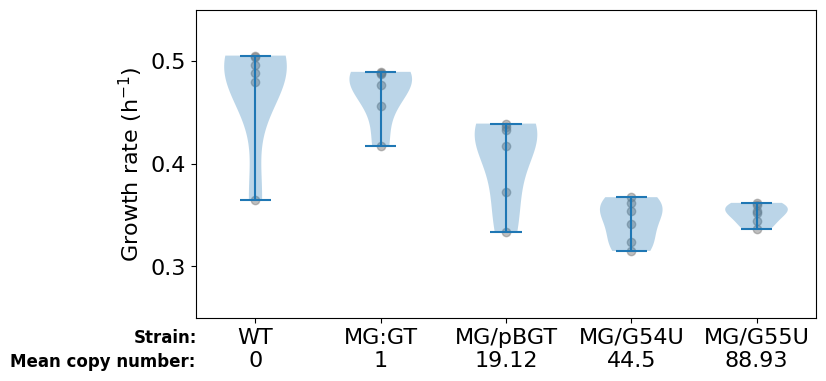

In [12]:
plt_strains_names=["WT\n0","MG:GT\n1","MG/pBGT\n19.12","MG/G54U\n44.5","MG/G55U\n88.93"]


fig=plt.figure(figsize=(8,4))
fig.set_facecolor('white')
plt.rcParams.update({'font.size': 16})

xx=[]
xxL=[]
mumaxs=[]
mumaxsL=[]
mumax_means=[]

for istrain,this_strain in enumerate(single_strains):
    this_df=many_fits_single_res[many_fits_single_res["strain"]==this_strain]
    this_mumaxs=list(this_df["mumax"])
    this_x2=[strain_pcns[istrain]]*len(this_mumaxs)
    this_x=[istrain]*len(this_mumaxs)
    xxL=xxL+this_x2
    mumaxsL=mumaxsL+this_mumaxs
    mumax_means.append(np.mean(this_mumaxs))
    xx=xx+this_x
    mumaxs.append(this_mumaxs)
    plt.scatter(this_x,this_mumaxs,alpha=.5,c='gray')

lr_plot=linregress(xxL,mumaxsL)
lry_plot=[x*lr_plot.slope+lr_plot.intercept for x in xxL]
#plt.plot(xx,lry_plot,'k',label="regression",lw=4,ls="-",alpha=.5)
#plt.annotate(r"$R^2$=""%s\np-value$<$0.05"%(round(lr_plot.rvalue**2,3)), xy=(0.6, 0.8), xycoords='axes fraction')

xdevs=[-.15,-.25,-13,-25,-25]
ydevs=[-.01,0,-0.005,0,-.03]

plotpcns=[int(round(x,0)) for x in strain_pcns]
single_strains2=["%s\n(%s)"%(s,p) for s,p in zip(single_strains,plotpcns)]
plt.xticks(range(0,5),labels=plt_strains_names)#,fontweight="bold")

plt.violinplot(mumaxs,positions=range(0,5))

fs=12
plt.annotate("Strain:", xy=(-.1,-.08),xycoords='axes fraction',fontweight='bold',fontsize=fs)
plt.annotate("Mean copy number:", xy=(-.3,-.16),xycoords='axes fraction',fontweight='bold',fontsize=fs)



plt.ylabel("Growth rate (h$^{-1}$)")#,fontweight="bold")


#plt.tight_layout()
plt.ylim([0.25, 0.55])
out_fig_name=sfig_path+"sFig-13.pdf"
print("Saving fig as: \n",out_fig_name)
plt.savefig(out_fig_name,bbox_inches = 'tight',pad_inches = 0.1)
plt.show()
